In [1]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [2]:
# More importing common libraries

from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization, Conv2DTranspose, Reshape, Conv2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [3]:
# Load the MNIST Data

fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [4]:
# Scale the inputs in range of (-1, +1) for better training
x_train, x_test = x_train / 255.0 * 2 - 1, x_test / 255.0 * 2 - 1

In [5]:
items = {0 : "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
          5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}

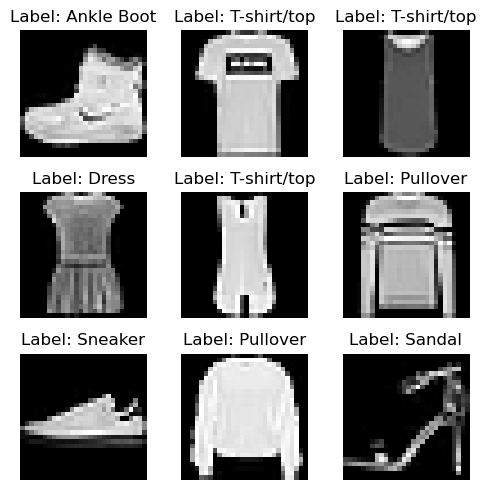

In [6]:
import matplotlib.pyplot as plt
# Function to display a grid of images
def display_images(images, labels, grid_size=(3, 3)):
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(5, 5))
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            index = i * grid_size[1] + j
            axes[i, j].imshow(images[index], cmap='gray')
            axes[i, j].set_title(f"Label: {items[labels[index]]}")
            axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

# Display a 3x3 grid of images from the training set
display_images(x_train, y_train, grid_size=(3, 3))

In [7]:
print ("x_train.shape:" ,x_train.shape)
print ("x_test.shape:" ,x_test.shape)

x_train.shape: (60000, 28, 28)
x_test.shape: (10000, 28, 28)


In [8]:
# Flatten the data
N, H, W = x_train.shape
D = H * W

In [9]:
# Dimensionality of the latent space
latent_dim = 100

In [ ]:
## Defining the generator model
def build_generator(latent_dim):
    i = Input(shape=(latent_dim,))
    x = Dense(7*7*256, use_bias=False)(i)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Reshape((7, 7, 256))(x)

    x = Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)

    model = Model(i, x)
    return model

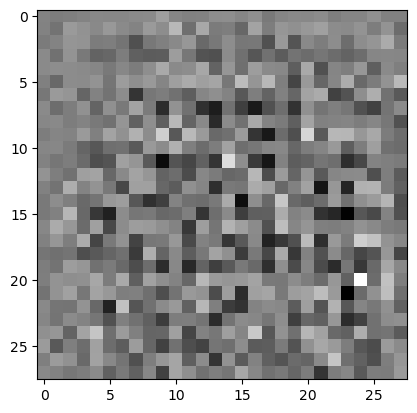

In [17]:
generator = build_generator(latent_dim)

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [18]:
# Defining the discriminator model
def build_discriminator(H,W,channels=1):
    i = Input(shape=(H,W, channels))
    x = Conv2D(64, (5, 5), strides=(2, 2), padding='same')(i)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    x = Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    x = Dense(1, activation="sigmoid")(x)

    model = Model(i, x)
    return model

In [19]:
# Compile both models in preparation for training

# Build and compile the discriminator
discriminator = build_discriminator(H,W)
discriminator.compile ( loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

# Build and compile the combined model
generator = build_generator(latent_dim)

In [20]:
generator.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_2 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization_3 (Batc  (None, 12544)            50176     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 12544)             0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 7, 7, 128)        819200    
 ranspose)                                                 

In [21]:
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0   

### Compile and Join ModelG/D

In [22]:
# Create an input to represent noise sample from latent space
z = Input(shape=(latent_dim,))

z.shape

TensorShape([None, 100])

In [23]:
# Pass noise through generator to get an image
img = generator(z)

In [25]:
# Make sure only the generator is trained
discriminator.trainable = False

In [26]:
# The true output is fake, but we label them real!
# Passing the output of Generator to the Discriminator

fake_pred = discriminator(img)

In [27]:
# Create the combined model object
combined_model_gen = Model(z, fake_pred)

In [28]:
# Compile the combined model
combined_model_gen.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [29]:
# Config

batch_size = 32
epochs = 30000
sample_period = 200 # every `sample_period` steps generate and save some data"

In [30]:
# Create batch labels to use when calling train_on_batch
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

# Store the losses
d_losses = []
g_losses = []

# Create a folder to store generated images
if not os.path.exists('gan_fashion_images'):
    os.makedirs('gan_fashion_images')

In [31]:
# A function to generate a grid of random samples from the generator and save them to a file

def sample_images(epoch):
    rows, cols = 5, 5
    noise = np.random.randn(rows * cols, latent_dim)
    imgs = generator.predict(noise)

    # Rescale images 0 - 1
    imgs = 0.5 * imgs + 0.5

    fig, axs = plt.subplots(rows, cols)
    idx = 0
    for i in range(rows):
        for j in range(cols):
            axs[i,j].imshow(imgs[idx, :, :, 0], cmap='gray')
            axs[i,j].axis('off')
            idx += 1
    fig.savefig("gan_fashion_mnist_images/%d.png" % epoch)
    plt.close()

### Build a function for Training the GAN

In [33]:
# Main training loop
for epoch in range(epochs):
  ###########################
  ### Train discriminator ###
  ###########################

    # Select a random batch of images
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    real_imgs = x_train[idx]

    # Generate fake images
    noise = np.random.randn(batch_size, latent_dim)
    fake_imgs = generator.predict(noise)

    # Train the discriminator
    # both loss and accuracy are returned
    d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
    d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
    d_loss = 0.5 * (d_loss_real + d_loss_fake)
    d_acc  = 0.5 * (d_acc_real + d_acc_fake)


    #######################
    ### Train generator ###
    #######################

    noise = np.random.randn(batch_size, latent_dim)
    g_loss = combined_model_gen.train_on_batch(noise, ones)

    # do it again!
    noise = np.random.randn(batch_size, latent_dim)
    g_loss = combined_model_gen.train_on_batch(noise, ones)

    # Save the losses
    d_losses.append(d_loss)
    g_losses.append(g_loss)

    if epoch % 100 == 0:
        print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss}, d_acc: {d_acc}, g_loss: {g_loss}")

    if epoch % sample_period == 0:
        sample_images(epoch)

1/1 [==============================] - 0s 495ms/step
epoch: 1/30000, d_loss: 0.6939062178134918, d_acc: 0.21875, g_loss: 0.6169586181640625
1/1 [==============================] - 0s 106ms/step
epoch: 101/30000, d_loss: 0.026396707631647587, d_acc: 1.0, g_loss: 3.3834205623861635e-06
1/1 [==============================] - 0s 109ms/step


1/1 [==============================] - 0s 122ms/step
epoch: 201/30000, d_loss: 0.025258128065615892, d_acc: 1.0, g_loss: 5.1521310524549335e-05
1/1 [==============================] - 0s 145ms/step
epoch: 301/30000, d_loss: 0.8518185615539551, d_acc: 0.15625, g_loss: 0.49422577023506165


1/1 [==============================] - 0s 109ms/step
epoch: 401/30000, d_loss: 0.7426380813121796, d_acc: 0.390625, g_loss: 0.6209107637405396
1/1 [==============================] - 0s 111ms/step


1/1 [==============================] - 0s 155ms/step
epoch: 501/30000, d_loss: 0.7302935719490051, d_acc: 0.328125, g_loss: 0.6021215915679932
1/1 [==============================] - 0s 147ms/step
epoch: 601/30000, d_loss: 0.7073444426059723, d_acc: 0.4375, g_loss: 0.6964021921157837
1/1 [==============================] - 0s 173ms/step


1/1 [==============================] - 0s 138ms/step
epoch: 701/30000, d_loss: 0.7053298950195312, d_acc: 0.375, g_loss: 0.6691830158233643
1/1 [==============================] - 0s 155ms/step


1/1 [==============================] - 0s 143ms/step
epoch: 801/30000, d_loss: 0.7002466320991516, d_acc: 0.484375, g_loss: 0.6748851537704468
1/1 [==============================] - 0s 156ms/step
epoch: 901/30000, d_loss: 0.6932860314846039, d_acc: 0.484375, g_loss: 0.6846604347229004
1/1 [==============================] - 0s 141ms/step


1/1 [==============================] - 0s 167ms/step
epoch: 1001/30000, d_loss: 0.6958671808242798, d_acc: 0.484375, g_loss: 0.6869733333587646
1/1 [==============================] - 0s 156ms/step


1/1 [==============================] - 0s 146ms/step
epoch: 1101/30000, d_loss: 0.7010112106800079, d_acc: 0.421875, g_loss: 0.7060677409172058
1/1 [==============================] - 0s 149ms/step
epoch: 1201/30000, d_loss: 0.6992301642894745, d_acc: 0.421875, g_loss: 0.7045093774795532
1/1 [==============================] - 0s 125ms/step


1/1 [==============================] - 0s 157ms/step
epoch: 1301/30000, d_loss: 0.7130100727081299, d_acc: 0.390625, g_loss: 0.6742368936538696
1/1 [==============================] - 0s 154ms/step


1/1 [==============================] - 0s 152ms/step
epoch: 1401/30000, d_loss: 0.697369247674942, d_acc: 0.453125, g_loss: 0.7007005214691162
1/1 [==============================] - 0s 95ms/step
epoch: 1501/30000, d_loss: 0.6939032673835754, d_acc: 0.5625, g_loss: 0.7073224782943726
1/1 [==============================] - 0s 168ms/step


1/1 [==============================] - 0s 48ms/step
epoch: 1601/30000, d_loss: 0.696082592010498, d_acc: 0.484375, g_loss: 0.7144589424133301
1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 48ms/step
epoch: 1701/30000, d_loss: 0.691639631986618, d_acc: 0.484375, g_loss: 0.7054111957550049
1/1 [==============================] - 0s 67ms/step
epoch: 1801/30000, d_loss: 0.70480877161026, d_acc: 0.359375, g_loss: 0.7002288103103638
1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 50ms/step
epoch: 1901/30000, d_loss: 0.6982643008232117, d_acc: 0.453125, g_loss: 0.6968280076980591
1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 50ms/step
epoch: 2001/30000, d_loss: 0.6956301331520081, d_acc: 0.421875, g_loss: 0.7227230668067932
1/1 [==============================] - 0s 74ms/step
epoch: 2101/30000, d_loss: 0.7119728028774261, d_acc: 0.484375, g_loss: 0.7046303153038025
1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 60ms/step
epoch: 2201/30000, d_loss: 0.7044413983821869, d_acc: 0.421875, g_loss: 0.7075175642967224
1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 57ms/step
epoch: 2301/30000, d_loss: 0.6900386214256287, d_acc: 0.5, g_loss: 0.6963180303573608
1/1 [==============================] - 0s 55ms/step
epoch: 2401/30000, d_loss: 0.6910145282745361, d_acc: 0.484375, g_loss: 0.6630222797393799
1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 51ms/step
epoch: 2501/30000, d_loss: 0.6839202046394348, d_acc: 0.59375, g_loss: 0.7487095594406128
1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 52ms/step
epoch: 2601/30000, d_loss: 0.7055498957633972, d_acc: 0.40625, g_loss: 0.6810320019721985
1/1 [==============================] - 0s 50ms/step
epoch: 2701/30000, d_loss: 0.6736918091773987, d_acc: 0.609375, g_loss: 0.7308437824249268
1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 50ms/step
epoch: 2801/30000, d_loss: 0.6766937077045441, d_acc: 0.640625, g_loss: 0.7020541429519653
1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 51ms/step
epoch: 2901/30000, d_loss: 0.6840120851993561, d_acc: 0.59375, g_loss: 0.6959294080734253
1/1 [==============================] - 0s 52ms/step
epoch: 3001/30000, d_loss: 0.7094012498855591, d_acc: 0.453125, g_loss: 0.6895674467086792
1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 54ms/step
epoch: 3101/30000, d_loss: 0.6935666799545288, d_acc: 0.484375, g_loss: 0.6969987154006958
1/1 [==============================] - 0s 55ms/step
epoch: 3201/30000, d_loss: 0.6670620739459991, d_acc: 0.59375, g_loss: 0.7168006896972656


1/1 [==============================] - 0s 55ms/step
epoch: 3301/30000, d_loss: 0.6961297988891602, d_acc: 0.5625, g_loss: 0.6824986934661865
1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 54ms/step
epoch: 3401/30000, d_loss: 0.6804011464118958, d_acc: 0.65625, g_loss: 0.6917954087257385
1/1 [==============================] - 0s 54ms/step
epoch: 3501/30000, d_loss: 0.6792945563793182, d_acc: 0.609375, g_loss: 0.727489173412323
1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 53ms/step
epoch: 3601/30000, d_loss: 0.6844047904014587, d_acc: 0.5625, g_loss: 0.7054778933525085
1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 81ms/step
epoch: 3701/30000, d_loss: 0.7104468941688538, d_acc: 0.453125, g_loss: 0.6969481110572815
1/1 [==============================] - 0s 54ms/step
epoch: 3801/30000, d_loss: 0.7063806653022766, d_acc: 0.40625, g_loss: 0.6821568012237549
1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 124ms/step
epoch: 3901/30000, d_loss: 0.6983225345611572, d_acc: 0.453125, g_loss: 0.7084013223648071
1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 68ms/step
epoch: 4001/30000, d_loss: 0.6879531145095825, d_acc: 0.578125, g_loss: 0.7056233882904053
1/1 [==============================] - 0s 61ms/step
epoch: 4101/30000, d_loss: 0.6817056238651276, d_acc: 0.578125, g_loss: 0.7307703495025635
1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 61ms/step
epoch: 4201/30000, d_loss: 0.7188913822174072, d_acc: 0.375, g_loss: 0.6995359659194946
1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 60ms/step
epoch: 4301/30000, d_loss: 0.6667285859584808, d_acc: 0.609375, g_loss: 0.7312477827072144
1/1 [==============================] - 0s 61ms/step
epoch: 4401/30000, d_loss: 0.6688593327999115, d_acc: 0.625, g_loss: 0.7369314432144165
1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 53ms/step
epoch: 4501/30000, d_loss: 0.6819471120834351, d_acc: 0.609375, g_loss: 0.7403833270072937
1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 68ms/step
epoch: 4601/30000, d_loss: 0.6947860717773438, d_acc: 0.484375, g_loss: 0.7315551042556763
1/1 [==============================] - 0s 60ms/step
epoch: 4701/30000, d_loss: 0.6908398866653442, d_acc: 0.484375, g_loss: 0.7243350744247437
1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 58ms/step
epoch: 4801/30000, d_loss: 0.6764860451221466, d_acc: 0.578125, g_loss: 0.6970490217208862
1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 61ms/step
epoch: 4901/30000, d_loss: 0.6979262828826904, d_acc: 0.546875, g_loss: 0.6687909364700317
1/1 [==============================] - 0s 60ms/step
epoch: 5001/30000, d_loss: 0.6888692677021027, d_acc: 0.53125, g_loss: 0.6806697249412537
1/1 [==============================] - 0s 75ms/step


1/1 [==============================] - 0s 60ms/step
epoch: 5101/30000, d_loss: 0.6742550730705261, d_acc: 0.640625, g_loss: 0.7133221626281738
1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 88ms/step
epoch: 5201/30000, d_loss: 0.7090068459510803, d_acc: 0.375, g_loss: 0.7058370113372803
1/1 [==============================] - 0s 74ms/step
epoch: 5301/30000, d_loss: 0.6859239935874939, d_acc: 0.578125, g_loss: 0.7091368436813354
1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 60ms/step
epoch: 5401/30000, d_loss: 0.6976538598537445, d_acc: 0.515625, g_loss: 0.707994818687439
1/1 [==============================] - 0s 66ms/step
epoch: 5501/30000, d_loss: 0.6955584287643433, d_acc: 0.578125, g_loss: 0.6921386122703552
1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 69ms/step
epoch: 5601/30000, d_loss: 0.6806954741477966, d_acc: 0.53125, g_loss: 0.7507099509239197
1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 61ms/step
epoch: 5701/30000, d_loss: 0.6645846962928772, d_acc: 0.65625, g_loss: 0.7449560165405273
1/1 [==============================] - 0s 65ms/step
epoch: 5801/30000, d_loss: 0.6898023188114166, d_acc: 0.5, g_loss: 0.6953282952308655
1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 67ms/step
epoch: 5901/30000, d_loss: 0.7138386368751526, d_acc: 0.453125, g_loss: 0.7076401710510254
1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 63ms/step
epoch: 6001/30000, d_loss: 0.6831977367401123, d_acc: 0.5625, g_loss: 0.6993536949157715
1/1 [==============================] - 0s 71ms/step
epoch: 6101/30000, d_loss: 0.6952804923057556, d_acc: 0.53125, g_loss: 0.705299973487854
1/1 [==============================] - 0s 106ms/step


1/1 [==============================] - 0s 67ms/step
epoch: 6201/30000, d_loss: 0.6762876212596893, d_acc: 0.578125, g_loss: 0.688544511795044
1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 72ms/step
epoch: 6301/30000, d_loss: 0.6984242498874664, d_acc: 0.5, g_loss: 0.6678915619850159
1/1 [==============================] - 0s 83ms/step
epoch: 6401/30000, d_loss: 0.6906258761882782, d_acc: 0.609375, g_loss: 0.7173519730567932
1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 70ms/step
epoch: 6501/30000, d_loss: 0.6961954832077026, d_acc: 0.4375, g_loss: 0.7192751169204712
1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 112ms/step
epoch: 6601/30000, d_loss: 0.704413890838623, d_acc: 0.484375, g_loss: 0.7019060254096985
1/1 [==============================] - 0s 66ms/step
epoch: 6701/30000, d_loss: 0.7057667672634125, d_acc: 0.453125, g_loss: 0.702392578125
1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 67ms/step
epoch: 6801/30000, d_loss: 0.7017369866371155, d_acc: 0.515625, g_loss: 0.7290685176849365
1/1 [==============================] - 0s 72ms/step


1/1 [==============================] - 0s 84ms/step
epoch: 6901/30000, d_loss: 0.7093149721622467, d_acc: 0.40625, g_loss: 0.6982433795928955
1/1 [==============================] - 0s 72ms/step
epoch: 7001/30000, d_loss: 0.6908642053604126, d_acc: 0.546875, g_loss: 0.7137148380279541
1/1 [==============================] - 0s 72ms/step


1/1 [==============================] - 0s 73ms/step
epoch: 7101/30000, d_loss: 0.6867689490318298, d_acc: 0.5, g_loss: 0.7012168169021606
1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 113ms/step
epoch: 7201/30000, d_loss: 0.7083202004432678, d_acc: 0.390625, g_loss: 0.7089614868164062
1/1 [==============================] - 0s 80ms/step
epoch: 7301/30000, d_loss: 0.6865911483764648, d_acc: 0.578125, g_loss: 0.7281097769737244
1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 101ms/step
epoch: 7401/30000, d_loss: 0.7059892117977142, d_acc: 0.4375, g_loss: 0.711762547492981
1/1 [==============================] - 0s 83ms/step
epoch: 7501/30000, d_loss: 0.6940096020698547, d_acc: 0.5625, g_loss: 0.7152152061462402


1/1 [==============================] - 0s 86ms/step
epoch: 7601/30000, d_loss: 0.6585685312747955, d_acc: 0.71875, g_loss: 0.7382838726043701
1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 87ms/step
epoch: 7701/30000, d_loss: 0.671075165271759, d_acc: 0.640625, g_loss: 0.6991003155708313
1/1 [==============================] - 0s 74ms/step
epoch: 7801/30000, d_loss: 0.6885056495666504, d_acc: 0.546875, g_loss: 0.71986985206604
1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 71ms/step
epoch: 7901/30000, d_loss: 0.6685652434825897, d_acc: 0.6875, g_loss: 0.7339181900024414
1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 76ms/step
epoch: 8001/30000, d_loss: 0.7085400521755219, d_acc: 0.359375, g_loss: 0.7060433626174927
1/1 [==============================] - 0s 71ms/step
epoch: 8101/30000, d_loss: 0.7150271534919739, d_acc: 0.375, g_loss: 0.686903178691864
1/1 [==============================] - 0s 74ms/step


1/1 [==============================] - 0s 77ms/step
epoch: 8201/30000, d_loss: 0.7032906711101532, d_acc: 0.4375, g_loss: 0.7039124965667725
1/1 [==============================] - 0s 74ms/step


1/1 [==============================] - 0s 77ms/step
epoch: 8301/30000, d_loss: 0.7061237692832947, d_acc: 0.453125, g_loss: 0.7319505214691162
1/1 [==============================] - 0s 76ms/step
epoch: 8401/30000, d_loss: 0.7074956893920898, d_acc: 0.375, g_loss: 0.7340813279151917
1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 77ms/step
epoch: 8501/30000, d_loss: 0.6846375465393066, d_acc: 0.515625, g_loss: 0.692348062992096
1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 77ms/step
epoch: 8601/30000, d_loss: 0.6882410645484924, d_acc: 0.5625, g_loss: 0.7200448513031006
1/1 [==============================] - 0s 76ms/step
epoch: 8701/30000, d_loss: 0.7108275294303894, d_acc: 0.40625, g_loss: 0.7122037410736084
1/1 [==============================] - 0s 75ms/step


1/1 [==============================] - 0s 78ms/step
epoch: 8801/30000, d_loss: 0.697182297706604, d_acc: 0.5, g_loss: 0.7403402328491211
1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 83ms/step
epoch: 8901/30000, d_loss: 0.6948240697383881, d_acc: 0.53125, g_loss: 0.7263530492782593
1/1 [==============================] - 0s 79ms/step
epoch: 9001/30000, d_loss: 0.6901983618736267, d_acc: 0.484375, g_loss: 0.6944237947463989
1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 81ms/step
epoch: 9101/30000, d_loss: 0.6976363658905029, d_acc: 0.53125, g_loss: 0.7348725199699402
1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 78ms/step
epoch: 9201/30000, d_loss: 0.7099412381649017, d_acc: 0.4375, g_loss: 0.6988316178321838
1/1 [==============================] - 0s 82ms/step
epoch: 9301/30000, d_loss: 0.6927572190761566, d_acc: 0.625, g_loss: 0.7049359083175659
1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 81ms/step
epoch: 9401/30000, d_loss: 0.703146904706955, d_acc: 0.4375, g_loss: 0.7092502117156982
1/1 [==============================] - 0s 81ms/step
epoch: 9501/30000, d_loss: 0.6806111931800842, d_acc: 0.53125, g_loss: 0.7434728741645813


1/1 [==============================] - 0s 83ms/step
epoch: 9601/30000, d_loss: 0.6831172406673431, d_acc: 0.546875, g_loss: 0.725458025932312
1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 80ms/step
epoch: 9701/30000, d_loss: 0.67183056473732, d_acc: 0.609375, g_loss: 0.7269402146339417
1/1 [==============================] - 0s 84ms/step
epoch: 9801/30000, d_loss: 0.6830247640609741, d_acc: 0.578125, g_loss: 0.7279675602912903
1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 116ms/step
epoch: 9901/30000, d_loss: 0.676558256149292, d_acc: 0.65625, g_loss: 0.7166916131973267
1/1 [==============================] - 0s 112ms/step


1/1 [==============================] - 0s 106ms/step
epoch: 10001/30000, d_loss: 0.6998598277568817, d_acc: 0.53125, g_loss: 0.7021998763084412
1/1 [==============================] - 0s 113ms/step
epoch: 10101/30000, d_loss: 0.6811551451683044, d_acc: 0.640625, g_loss: 0.7410296201705933
1/1 [==============================] - 0s 107ms/step


1/1 [==============================] - 0s 121ms/step
epoch: 10201/30000, d_loss: 0.6732454001903534, d_acc: 0.640625, g_loss: 0.7061423063278198
1/1 [==============================] - 0s 111ms/step


1/1 [==============================] - 0s 115ms/step
epoch: 10301/30000, d_loss: 0.6848274171352386, d_acc: 0.578125, g_loss: 0.7153276205062866
1/1 [==============================] - 0s 121ms/step
epoch: 10401/30000, d_loss: 0.6826462745666504, d_acc: 0.578125, g_loss: 0.7149837613105774
1/1 [==============================] - 0s 124ms/step


1/1 [==============================] - 0s 118ms/step
epoch: 10501/30000, d_loss: 0.7057974338531494, d_acc: 0.515625, g_loss: 0.7282679080963135
1/1 [==============================] - 0s 114ms/step


1/1 [==============================] - 0s 141ms/step
epoch: 10601/30000, d_loss: 0.7063378989696503, d_acc: 0.46875, g_loss: 0.7165122032165527
1/1 [==============================] - 0s 120ms/step
epoch: 10701/30000, d_loss: 0.6924738883972168, d_acc: 0.515625, g_loss: 0.6973790526390076
1/1 [==============================] - 0s 144ms/step


1/1 [==============================] - 0s 113ms/step
epoch: 10801/30000, d_loss: 0.7010380029678345, d_acc: 0.515625, g_loss: 0.718294620513916
1/1 [==============================] - 0s 123ms/step


1/1 [==============================] - 0s 116ms/step
epoch: 10901/30000, d_loss: 0.6842389702796936, d_acc: 0.59375, g_loss: 0.7046211361885071
1/1 [==============================] - 0s 119ms/step
epoch: 11001/30000, d_loss: 0.7089178562164307, d_acc: 0.46875, g_loss: 0.7396246790885925
1/1 [==============================] - 0s 121ms/step


1/1 [==============================] - 0s 117ms/step
epoch: 11101/30000, d_loss: 0.6720478534698486, d_acc: 0.625, g_loss: 0.7370109558105469
1/1 [==============================] - 0s 130ms/step


1/1 [==============================] - 0s 135ms/step
epoch: 11201/30000, d_loss: 0.6828281581401825, d_acc: 0.59375, g_loss: 0.7361061573028564
1/1 [==============================] - 0s 128ms/step
epoch: 11301/30000, d_loss: 0.7048577666282654, d_acc: 0.546875, g_loss: 0.736207127571106
1/1 [==============================] - 0s 118ms/step


1/1 [==============================] - 0s 124ms/step
epoch: 11401/30000, d_loss: 0.7115194499492645, d_acc: 0.4375, g_loss: 0.717796266078949
1/1 [==============================] - 0s 120ms/step


1/1 [==============================] - 0s 128ms/step
epoch: 11501/30000, d_loss: 0.7119870781898499, d_acc: 0.5, g_loss: 0.7117397785186768
1/1 [==============================] - 0s 119ms/step
epoch: 11601/30000, d_loss: 0.6773325204849243, d_acc: 0.609375, g_loss: 0.7363978028297424
1/1 [==============================] - 0s 126ms/step


1/1 [==============================] - 0s 120ms/step
epoch: 11701/30000, d_loss: 0.6910243630409241, d_acc: 0.515625, g_loss: 0.7249770164489746
1/1 [==============================] - 0s 131ms/step


1/1 [==============================] - 0s 128ms/step
epoch: 11801/30000, d_loss: 0.6777425408363342, d_acc: 0.640625, g_loss: 0.6974368691444397
1/1 [==============================] - 0s 128ms/step
epoch: 11901/30000, d_loss: 0.6688768863677979, d_acc: 0.703125, g_loss: 0.7334210872650146
1/1 [==============================] - 0s 131ms/step


1/1 [==============================] - 0s 119ms/step
epoch: 12001/30000, d_loss: 0.6989108920097351, d_acc: 0.53125, g_loss: 0.7089523077011108
1/1 [==============================] - 0s 156ms/step


1/1 [==============================] - 0s 126ms/step
epoch: 12101/30000, d_loss: 0.6971873939037323, d_acc: 0.5, g_loss: 0.7507719993591309
1/1 [==============================] - 0s 149ms/step
epoch: 12201/30000, d_loss: 0.7032790780067444, d_acc: 0.46875, g_loss: 0.6972404718399048
1/1 [==============================] - 0s 132ms/step


1/1 [==============================] - 0s 127ms/step
epoch: 12301/30000, d_loss: 0.7008313536643982, d_acc: 0.453125, g_loss: 0.7148367166519165
1/1 [==============================] - 0s 126ms/step


1/1 [==============================] - 0s 125ms/step
epoch: 12401/30000, d_loss: 0.6943440139293671, d_acc: 0.515625, g_loss: 0.718237042427063
1/1 [==============================] - 0s 132ms/step
epoch: 12501/30000, d_loss: 0.6965236365795135, d_acc: 0.5, g_loss: 0.7152550220489502
1/1 [==============================] - 0s 135ms/step


1/1 [==============================] - 0s 131ms/step
epoch: 12601/30000, d_loss: 0.6809047162532806, d_acc: 0.59375, g_loss: 0.7247684597969055
1/1 [==============================] - 0s 130ms/step


1/1 [==============================] - 0s 127ms/step
epoch: 12701/30000, d_loss: 0.6681714057922363, d_acc: 0.578125, g_loss: 0.718654215335846
1/1 [==============================] - 0s 124ms/step
epoch: 12801/30000, d_loss: 0.692494809627533, d_acc: 0.578125, g_loss: 0.7148277759552002
1/1 [==============================] - 0s 134ms/step


1/1 [==============================] - 0s 165ms/step
epoch: 12901/30000, d_loss: 0.6800382435321808, d_acc: 0.578125, g_loss: 0.7157065868377686
1/1 [==============================] - 0s 146ms/step


1/1 [==============================] - 0s 142ms/step
epoch: 13001/30000, d_loss: 0.6758611500263214, d_acc: 0.5625, g_loss: 0.7154433727264404
1/1 [==============================] - 0s 165ms/step
epoch: 13101/30000, d_loss: 0.6889386475086212, d_acc: 0.484375, g_loss: 0.7144637703895569
1/1 [==============================] - 0s 158ms/step


1/1 [==============================] - 0s 161ms/step
epoch: 13201/30000, d_loss: 0.6932274401187897, d_acc: 0.546875, g_loss: 0.7281770706176758
1/1 [==============================] - 0s 128ms/step


1/1 [==============================] - 0s 139ms/step
epoch: 13301/30000, d_loss: 0.6790016889572144, d_acc: 0.53125, g_loss: 0.7067843675613403
1/1 [==============================] - 0s 164ms/step
epoch: 13401/30000, d_loss: 0.6703330874443054, d_acc: 0.625, g_loss: 0.7511584162712097
1/1 [==============================] - 0s 134ms/step


1/1 [==============================] - 0s 166ms/step
epoch: 13501/30000, d_loss: 0.6724314093589783, d_acc: 0.59375, g_loss: 0.7213115692138672
1/1 [==============================] - 0s 165ms/step


1/1 [==============================] - 0s 165ms/step
epoch: 13601/30000, d_loss: 0.7085629999637604, d_acc: 0.46875, g_loss: 0.718950092792511
1/1 [==============================] - 0s 151ms/step
epoch: 13701/30000, d_loss: 0.7012882828712463, d_acc: 0.484375, g_loss: 0.7159814834594727
1/1 [==============================] - 0s 136ms/step


1/1 [==============================] - 0s 147ms/step
epoch: 13801/30000, d_loss: 0.6644408702850342, d_acc: 0.625, g_loss: 0.7127954363822937
1/1 [==============================] - 0s 143ms/step


1/1 [==============================] - 0s 162ms/step
epoch: 13901/30000, d_loss: 0.6891708374023438, d_acc: 0.53125, g_loss: 0.7058764696121216
1/1 [==============================] - 0s 143ms/step
epoch: 14001/30000, d_loss: 0.6824688017368317, d_acc: 0.515625, g_loss: 0.7192326188087463
1/1 [==============================] - 0s 147ms/step


1/1 [==============================] - 0s 149ms/step
epoch: 14101/30000, d_loss: 0.7003992199897766, d_acc: 0.484375, g_loss: 0.7221487760543823
1/1 [==============================] - 0s 162ms/step


1/1 [==============================] - 0s 143ms/step
epoch: 14201/30000, d_loss: 0.6803619265556335, d_acc: 0.515625, g_loss: 0.7296797037124634
1/1 [==============================] - 0s 145ms/step
epoch: 14301/30000, d_loss: 0.6932914853096008, d_acc: 0.421875, g_loss: 0.7047262191772461
1/1 [==============================] - 0s 153ms/step


1/1 [==============================] - 0s 151ms/step
epoch: 14401/30000, d_loss: 0.6838216185569763, d_acc: 0.546875, g_loss: 0.7241538763046265
1/1 [==============================] - 0s 155ms/step


1/1 [==============================] - 0s 154ms/step
epoch: 14501/30000, d_loss: 0.6948103308677673, d_acc: 0.546875, g_loss: 0.7255792617797852
1/1 [==============================] - 0s 181ms/step
epoch: 14601/30000, d_loss: 0.6709982752799988, d_acc: 0.5625, g_loss: 0.709671139717102
1/1 [==============================] - 0s 153ms/step


1/1 [==============================] - 0s 156ms/step
epoch: 14701/30000, d_loss: 0.6984476745128632, d_acc: 0.484375, g_loss: 0.716800332069397
1/1 [==============================] - 0s 151ms/step


1/1 [==============================] - 0s 157ms/step
epoch: 14801/30000, d_loss: 0.6798204779624939, d_acc: 0.625, g_loss: 0.7218627333641052
1/1 [==============================] - 0s 151ms/step
epoch: 14901/30000, d_loss: 0.6885023415088654, d_acc: 0.484375, g_loss: 0.6763272881507874
1/1 [==============================] - 0s 149ms/step


1/1 [==============================] - 0s 178ms/step
epoch: 15001/30000, d_loss: 0.6999323070049286, d_acc: 0.46875, g_loss: 0.693358302116394
1/1 [==============================] - 0s 152ms/step


1/1 [==============================] - 0s 155ms/step
epoch: 15101/30000, d_loss: 0.6890645027160645, d_acc: 0.546875, g_loss: 0.7488229274749756
1/1 [==============================] - 0s 157ms/step
epoch: 15201/30000, d_loss: 0.6936500668525696, d_acc: 0.515625, g_loss: 0.7388039231300354
1/1 [==============================] - 0s 149ms/step


1/1 [==============================] - 0s 176ms/step
epoch: 15301/30000, d_loss: 0.6802766621112823, d_acc: 0.578125, g_loss: 0.7240914106369019
1/1 [==============================] - 0s 181ms/step


1/1 [==============================] - 0s 177ms/step
epoch: 15401/30000, d_loss: 0.6890312135219574, d_acc: 0.625, g_loss: 0.7215560078620911
1/1 [==============================] - 0s 182ms/step
epoch: 15501/30000, d_loss: 0.6958497762680054, d_acc: 0.515625, g_loss: 0.7445046901702881
1/1 [==============================] - 0s 182ms/step


1/1 [==============================] - 0s 178ms/step
epoch: 15601/30000, d_loss: 0.6870356798171997, d_acc: 0.484375, g_loss: 0.7867176532745361
1/1 [==============================] - 0s 179ms/step


1/1 [==============================] - 0s 161ms/step
epoch: 15701/30000, d_loss: 0.6833853423595428, d_acc: 0.59375, g_loss: 0.7344406843185425
1/1 [==============================] - 0s 150ms/step
epoch: 15801/30000, d_loss: 0.7016417384147644, d_acc: 0.484375, g_loss: 0.7132852077484131
1/1 [==============================] - 0s 156ms/step


1/1 [==============================] - 0s 155ms/step
epoch: 15901/30000, d_loss: 0.691765308380127, d_acc: 0.453125, g_loss: 0.7065108418464661
1/1 [==============================] - 0s 183ms/step


1/1 [==============================] - 0s 175ms/step
epoch: 16001/30000, d_loss: 0.7115691602230072, d_acc: 0.4375, g_loss: 0.7102928161621094
1/1 [==============================] - 0s 166ms/step
epoch: 16101/30000, d_loss: 0.6984123289585114, d_acc: 0.421875, g_loss: 0.6903475522994995
1/1 [==============================] - 0s 167ms/step


1/1 [==============================] - 0s 181ms/step
epoch: 16201/30000, d_loss: 0.7169331908226013, d_acc: 0.421875, g_loss: 0.7135034799575806
1/1 [==============================] - 0s 158ms/step


1/1 [==============================] - 0s 175ms/step
epoch: 16301/30000, d_loss: 0.7290127873420715, d_acc: 0.453125, g_loss: 0.6999638676643372
1/1 [==============================] - 0s 165ms/step
epoch: 16401/30000, d_loss: 0.6874445378780365, d_acc: 0.515625, g_loss: 0.7138179540634155
1/1 [==============================] - 0s 151ms/step


1/1 [==============================] - 0s 157ms/step
epoch: 16501/30000, d_loss: 0.6993114054203033, d_acc: 0.5, g_loss: 0.6996190547943115
1/1 [==============================] - 0s 161ms/step


1/1 [==============================] - 0s 150ms/step
epoch: 16601/30000, d_loss: 0.6984559595584869, d_acc: 0.453125, g_loss: 0.7040771245956421
1/1 [==============================] - 0s 186ms/step
epoch: 16701/30000, d_loss: 0.6829512119293213, d_acc: 0.515625, g_loss: 0.7461991310119629
1/1 [==============================] - 0s 193ms/step


1/1 [==============================] - 0s 188ms/step
epoch: 16801/30000, d_loss: 0.6991188526153564, d_acc: 0.53125, g_loss: 0.6994795799255371
1/1 [==============================] - 0s 187ms/step
epoch: 16901/30000, d_loss: 0.7069452404975891, d_acc: 0.53125, g_loss: 0.7148866057395935


1/1 [==============================] - 0s 166ms/step
epoch: 17001/30000, d_loss: 0.7214872241020203, d_acc: 0.453125, g_loss: 0.7201391458511353
1/1 [==============================] - 0s 178ms/step


1/1 [==============================] - 0s 190ms/step
epoch: 17101/30000, d_loss: 0.6915480494499207, d_acc: 0.53125, g_loss: 0.7421347498893738
1/1 [==============================] - 0s 192ms/step
epoch: 17201/30000, d_loss: 0.7123887240886688, d_acc: 0.421875, g_loss: 0.7108674049377441
1/1 [==============================] - 0s 195ms/step


1/1 [==============================] - 0s 198ms/step
epoch: 17301/30000, d_loss: 0.6899048388004303, d_acc: 0.5, g_loss: 0.7312754392623901
1/1 [==============================] - 0s 199ms/step


1/1 [==============================] - 0s 192ms/step
epoch: 17401/30000, d_loss: 0.6892664134502411, d_acc: 0.5, g_loss: 0.7263269424438477
1/1 [==============================] - 0s 492ms/step
epoch: 17501/30000, d_loss: 0.7187275886535645, d_acc: 0.390625, g_loss: 0.6949524879455566
1/1 [==============================] - 1s 534ms/step


1/1 [==============================] - 0s 462ms/step
epoch: 17601/30000, d_loss: 0.6998182237148285, d_acc: 0.515625, g_loss: 0.7151392698287964
1/1 [==============================] - 1s 589ms/step


1/1 [==============================] - 1s 545ms/step
epoch: 17701/30000, d_loss: 0.6720300912857056, d_acc: 0.625, g_loss: 0.7064444422721863
1/1 [==============================] - 0s 472ms/step
epoch: 17801/30000, d_loss: 0.7045950591564178, d_acc: 0.453125, g_loss: 0.7078153491020203
1/1 [==============================] - 0s 458ms/step


1/1 [==============================] - 1s 575ms/step
epoch: 17901/30000, d_loss: 0.6938940286636353, d_acc: 0.515625, g_loss: 0.6959871053695679
1/1 [==============================] - 0s 469ms/step


1/1 [==============================] - 1s 658ms/step
epoch: 18001/30000, d_loss: 0.6947035193443298, d_acc: 0.5625, g_loss: 0.7228274345397949
1/1 [==============================] - 1s 590ms/step
epoch: 18101/30000, d_loss: 0.694456160068512, d_acc: 0.515625, g_loss: 0.7194047570228577
1/1 [==============================] - 0s 472ms/step


1/1 [==============================] - 1s 590ms/step
epoch: 18201/30000, d_loss: 0.6930347979068756, d_acc: 0.53125, g_loss: 0.7224787473678589
1/1 [==============================] - 1s 525ms/step


1/1 [==============================] - 0s 398ms/step
epoch: 18301/30000, d_loss: 0.6648758351802826, d_acc: 0.671875, g_loss: 0.7237629890441895
1/1 [==============================] - 0s 487ms/step
epoch: 18401/30000, d_loss: 0.6801360547542572, d_acc: 0.59375, g_loss: 0.6995629072189331
1/1 [==============================] - 1s 559ms/step


1/1 [==============================] - 1s 762ms/step
epoch: 18501/30000, d_loss: 0.7200148105621338, d_acc: 0.453125, g_loss: 0.7284356355667114
1/1 [==============================] - 1s 532ms/step


1/1 [==============================] - 1s 633ms/step
epoch: 18601/30000, d_loss: 0.6902624070644379, d_acc: 0.5, g_loss: 0.7204000949859619
1/1 [==============================] - 1s 748ms/step
epoch: 18701/30000, d_loss: 0.6933456659317017, d_acc: 0.578125, g_loss: 0.7330557107925415
1/1 [==============================] - 1s 606ms/step


1/1 [==============================] - 1s 510ms/step
epoch: 18801/30000, d_loss: 0.6761770844459534, d_acc: 0.5, g_loss: 0.7668853998184204
1/1 [==============================] - 1s 560ms/step


1/1 [==============================] - 1s 626ms/step
epoch: 18901/30000, d_loss: 0.6782039999961853, d_acc: 0.5625, g_loss: 0.7255887985229492
1/1 [==============================] - 0s 201ms/step
epoch: 19001/30000, d_loss: 0.6744050979614258, d_acc: 0.65625, g_loss: 0.7013251781463623
1/1 [==============================] - 0s 184ms/step


1/1 [==============================] - 0s 204ms/step
epoch: 19101/30000, d_loss: 0.6810892820358276, d_acc: 0.5, g_loss: 0.7040971517562866
1/1 [==============================] - 0s 186ms/step


1/1 [==============================] - 0s 178ms/step
epoch: 19201/30000, d_loss: 0.7053678035736084, d_acc: 0.46875, g_loss: 0.7347704172134399
1/1 [==============================] - 0s 210ms/step
epoch: 19301/30000, d_loss: 0.6902210116386414, d_acc: 0.5625, g_loss: 0.6973469257354736
1/1 [==============================] - 0s 202ms/step


1/1 [==============================] - 0s 183ms/step
epoch: 19401/30000, d_loss: 0.70283642411232, d_acc: 0.578125, g_loss: 0.7053931355476379
1/1 [==============================] - 0s 214ms/step


1/1 [==============================] - 0s 216ms/step
epoch: 19501/30000, d_loss: 0.6886096596717834, d_acc: 0.453125, g_loss: 0.7209991216659546
1/1 [==============================] - 0s 198ms/step
epoch: 19601/30000, d_loss: 0.6974531412124634, d_acc: 0.4375, g_loss: 0.7174854278564453
1/1 [==============================] - 0s 189ms/step


1/1 [==============================] - 0s 187ms/step
epoch: 19701/30000, d_loss: 0.7008568942546844, d_acc: 0.53125, g_loss: 0.7246402502059937
1/1 [==============================] - 0s 214ms/step


1/1 [==============================] - 0s 182ms/step
epoch: 19801/30000, d_loss: 0.6765976846218109, d_acc: 0.59375, g_loss: 0.7067916393280029
1/1 [==============================] - 0s 212ms/step
epoch: 19901/30000, d_loss: 0.6590967178344727, d_acc: 0.578125, g_loss: 0.7293106317520142
1/1 [==============================] - 0s 184ms/step


1/1 [==============================] - 0s 206ms/step
epoch: 20001/30000, d_loss: 0.6912376880645752, d_acc: 0.578125, g_loss: 0.7112374305725098
1/1 [==============================] - 0s 210ms/step


KeyboardInterrupt: 

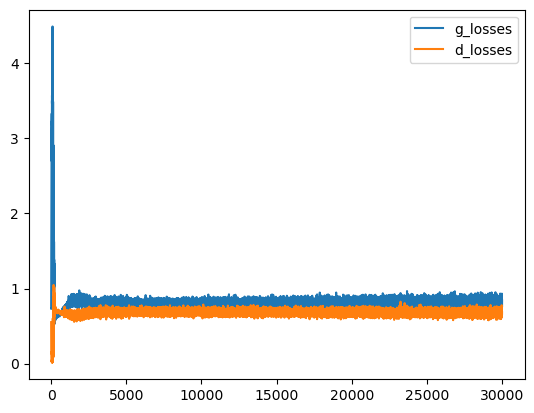

In [32]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

In [33]:
!dir gan_images

 Volume in drive C is Windows
 Volume Serial Number is F01D-1899

 Directory of C:\Users\TEJKIRAN\GAN\gan_images

08-08-2024  16:43    <DIR>          .
08-08-2024  16:52    <DIR>          ..
08-08-2024  10:55           185,434 0.png
08-08-2024  10:57           160,463 1000.png
08-08-2024  11:26            89,128 10000.png
08-08-2024  11:27           103,894 10200.png
08-08-2024  11:28            91,329 10400.png
08-08-2024  11:29            92,284 10600.png
08-08-2024  11:29            97,703 10800.png
08-08-2024  11:30            92,350 11000.png
08-08-2024  11:31           101,260 11200.png
08-08-2024  11:32            88,989 11400.png
08-08-2024  11:33            97,815 11600.png
08-08-2024  11:34            94,211 11800.png
08-08-2024  10:58           154,930 1200.png
08-08-2024  11:35            96,521 12000.png
08-08-2024  11:36            98,957 12200.png
08-08-2024  11:37            89,974 12400.png
08-08-2024  11:39            83,942 12600.png
08-08-2024  11:42            89,9

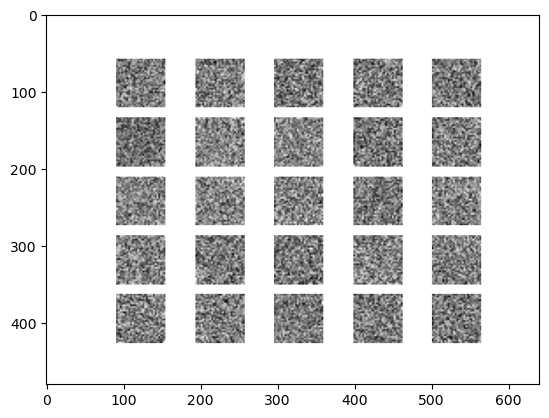

In [34]:
from skimage.io import imread
a = imread('gan_images/0.png')
plt.imshow(a)

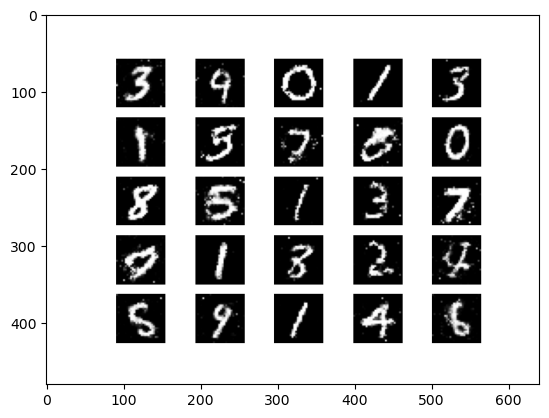

In [35]:
from skimage.io import imread
a = imread('gan_images/28000.png')
plt.imshow(a)

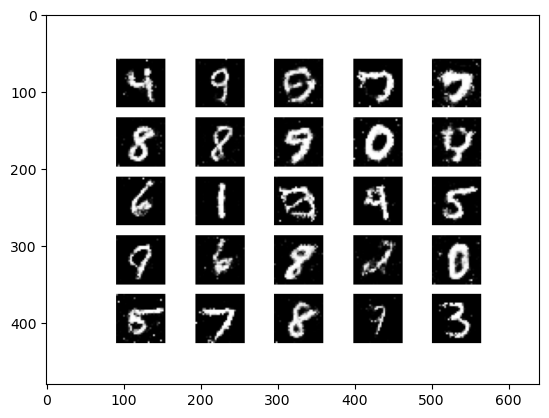

In [36]:
from skimage.io import imread
a = imread('gan_images/29800.png')
plt.imshow(a)